Imports

In [462]:
import pandas as pd
import numpy as np

from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error,mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text

import xgboost as xgb

import pickle

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Get data

In [463]:
df = pd.read_csv('/datasets/human_age_prediction.csv')

df.iloc[0].to_dict()

{'Gender': 'Male',
 'Height (cm)': 171.14835857585234,
 'Weight (kg)': 86.18519686940489,
 'Blood Pressure (s/d)': '151/109',
 'Cholesterol Level (mg/dL)': 259.46581350104714,
 'BMI': 29.423016908813725,
 'Blood Glucose Level (mg/dL)': 157.65284793866718,
 'Bone Density (g/cm²)': 0.1328682798964727,
 'Vision Sharpness': 0.2,
 'Hearing Ability (dB)': 58.78619834245858,
 'Physical Activity Level': 'Moderate',
 'Smoking Status': 'Former',
 'Alcohol Consumption': nan,
 'Diet': 'Low-carb',
 'Chronic Diseases': nan,
 'Medication Use': nan,
 'Family History': nan,
 'Cognitive Function': 44.05917162252895,
 'Mental Health Status': 'Good',
 'Sleep Patterns': 'Insomnia',
 'Stress Levels': 2.797064039425237,
 'Pollution Exposure': 5.142344384136116,
 'Sun Exposure': 7.108974826344509,
 'Education Level': nan,
 'Income Level': 'Medium',
 'Age (years)': 89}

Data preparation

In [464]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,gender,height_(cm),weight_(kg),blood_pressure_(s/d),cholesterol_level_(mg/dl),bmi,blood_glucose_level_(mg/dl),bone_density_(g/cm²),vision_sharpness,hearing_ability_(db),...,family_history,cognitive_function,mental_health_status,sleep_patterns,stress_levels,pollution_exposure,sun_exposure,education_level,income_level,age_(years)
0,Male,171.148359,86.185197,151/109,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,...,NaN,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,NaN,Medium,89
1,Male,172.946206,79.641937,134/112,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,...,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77
2,Female,155.945488,49.167058,160/101,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,...,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,NaN,Medium,70
3,Female,169.078298,56.017921,133/94,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,...,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,NaN,Low,52
4,Female,163.758355,73.966304,170/106,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,...,NaN,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79


In [465]:
df.isnull().sum()

,0
gender,0
height_(cm),0
weight_(kg),0
blood_pressure_(s/d),0
cholesterol_level_(mg/dl),0
bmi,0
blood_glucose_level_(mg/dl),0
bone_density_(g/cm²),0
vision_sharpness,0
hearing_ability_(db),0


In [466]:
df.alcohol_consumption[
    ~df.alcohol_consumption.isnull()
].iloc[0]

'Occasional'

In [467]:
df.chronic_diseases[
    ~df.chronic_diseases.isnull()
].iloc[0]

'Hypertension'

In [468]:
df.medication_use[
    ~df.medication_use.isnull()
].iloc[0]

'Regular'

In [469]:
df.family_history[
    ~df.family_history.isnull()
].iloc[0]

'Heart Disease'

In [470]:
df.education_level[
    ~df.education_level.isnull()
].iloc[0]

'Undergraduate'

In [471]:
df.alcohol_consumption = df.alcohol_consumption.fillna('Unknown')
df.chronic_diseases = df.chronic_diseases.fillna('Unknown')
df.medication_use = df.medication_use.fillna('Unknown')
df.family_history = df.family_history.fillna('Unknown')
df.education_level = df.education_level.fillna('Unknown')

df.head()

,gender,height_(cm),weight_(kg),blood_pressure_(s/d),cholesterol_level_(mg/dl),bmi,blood_glucose_level_(mg/dl),bone_density_(g/cm²),vision_sharpness,hearing_ability_(db),...,family_history,cognitive_function,mental_health_status,sleep_patterns,stress_levels,pollution_exposure,sun_exposure,education_level,income_level,age_(years)
0,Male,171.148359,86.185197,151/109,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,...,Unknown,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,Unknown,Medium,89
1,Male,172.946206,79.641937,134/112,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,...,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77
2,Female,155.945488,49.167058,160/101,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,...,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,Unknown,Medium,70
3,Female,169.078298,56.017921,133/94,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,...,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,Unknown,Low,52
4,Female,163.758355,73.966304,170/106,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,...,Unknown,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79


Feature engineering

<Axes: xlabel='age_(years)', ylabel='Count'>

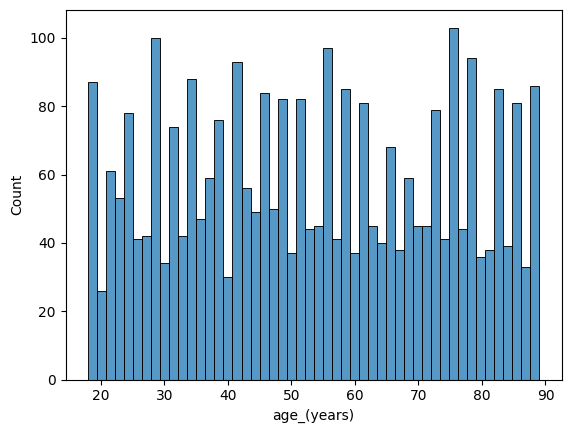

In [472]:
sns.histplot(df['age_(years)'], bins=50)

In [473]:
df.dtypes

,0
gender,object
height_(cm),float64
weight_(kg),float64
blood_pressure_(s/d),object
cholesterol_level_(mg/dl),float64
bmi,float64
blood_glucose_level_(mg/dl),float64
bone_density_(g/cm²),float64
vision_sharpness,float64
hearing_ability_(db),float64


In [474]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

categorical_features = df.select_dtypes(include=['object']).columns

numerical_features, categorical_features

(Index(['height_(cm)', 'weight_(kg)', 'cholesterol_level_(mg/dl)', 'bmi',
        'blood_glucose_level_(mg/dl)', 'bone_density_(g/cm²)',
        'vision_sharpness', 'hearing_ability_(db)', 'cognitive_function',
        'stress_levels', 'pollution_exposure', 'sun_exposure', 'age_(years)'],
       dtype='object'),
 Index(['gender', 'blood_pressure_(s/d)', 'physical_activity_level',
        'smoking_status', 'alcohol_consumption', 'diet', 'chronic_diseases',
        'medication_use', 'family_history', 'mental_health_status',
        'sleep_patterns', 'education_level', 'income_level'],
       dtype='object'))

In [475]:
for i in numerical_features:
  print('\t'+i)
  print(df[numerical_features].corrwith(df[i]).abs())
  print('\t----------')

	height_(cm)
height_(cm)                    1.000000
weight_(kg)                    0.398371
cholesterol_level_(mg/dl)      0.027233
bmi                            0.222789
blood_glucose_level_(mg/dl)    0.011990
bone_density_(g/cm²)           0.023558
vision_sharpness               0.009272
hearing_ability_(db)           0.009461
cognitive_function             0.018231
stress_levels                  0.006537
pollution_exposure             0.028681
sun_exposure                   0.001900
age_(years)                    0.020322
dtype: float64
	----------
	weight_(kg)
height_(cm)                    0.398371
weight_(kg)                    1.000000
cholesterol_level_(mg/dl)      0.041859
bmi                            0.800150
blood_glucose_level_(mg/dl)    0.015960
bone_density_(g/cm²)           0.008140
vision_sharpness               0.000436
hearing_ability_(db)           0.008944
cognitive_function             0.006220
stress_levels                  0.016620
pollution_exposure         

bone_density_(g/cm²), vision_sharpness, hearing_ability_(db), cognitive_function, cholesterol_level_(mg/dl), blood_glucose_level_(mg/dl)

In [476]:

def mutual_info_y_score(series):
    return mutual_info_score(series, df['age_(years)'])

# appling function to each categorical series
mis = df[categorical_features].apply(mutual_info_y_score).round(2)
mis.sort_values(ascending=False)

,0
blood_pressure_(s/d),3.49
smoking_status,0.06
diet,0.04
chronic_diseases,0.04
family_history,0.04
mental_health_status,0.04
education_level,0.04
physical_activity_level,0.03
medication_use,0.03
alcohol_consumption,0.02


In [477]:
# use blood_pressure_(s/d) feature
df['systolic'] = df['blood_pressure_(s/d)'].apply(lambda x: x.split('/')[0]).astype(int)
df['diastolic'] = df['blood_pressure_(s/d)'].apply(lambda x: x.split('/')[1]).astype(int)

df['pulse_pressure'] = df.systolic - df.diastolic

df.head()

,gender,height_(cm),weight_(kg),blood_pressure_(s/d),cholesterol_level_(mg/dl),bmi,blood_glucose_level_(mg/dl),bone_density_(g/cm²),vision_sharpness,hearing_ability_(db),...,sleep_patterns,stress_levels,pollution_exposure,sun_exposure,education_level,income_level,age_(years),systolic,diastolic,pulse_pressure
0,Male,171.148359,86.185197,151/109,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,...,Insomnia,2.797064,5.142344,7.108975,Unknown,Medium,89,151,109,42
1,Male,172.946206,79.641937,134/112,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,...,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77,134,112,22
2,Female,155.945488,49.167058,160/101,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,...,Insomnia,9.234637,8.500386,5.393408,Unknown,Medium,70,160,101,59
3,Female,169.078298,56.017921,133/94,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,...,Insomnia,4.693446,7.555511,2.745578,Unknown,Low,52,133,94,39
4,Female,163.758355,73.966304,170/106,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,...,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79,170,106,64


In [478]:
# use bone density
def categorize_bone_density(value):
    if value > 1.0:
        return 'Normal'
    elif 0.8 <= value <= 1.0:
        return 'Osteopenia'
    else:
        return 'Osteoporosis'

df['bone_density_category'] = df['bone_density_(g/cm²)'].apply(categorize_bone_density)

df.bone_density_category.value_counts()

,count
bone_density_category,
Normal,1374
Osteoporosis,1191
Osteopenia,435


In [479]:
df['bone_density_decline_rate'] = df['bone_density_(g/cm²)'] / df['age_(years)']

df.head()

,gender,height_(cm),weight_(kg),blood_pressure_(s/d),cholesterol_level_(mg/dl),bmi,blood_glucose_level_(mg/dl),bone_density_(g/cm²),vision_sharpness,hearing_ability_(db),...,pollution_exposure,sun_exposure,education_level,income_level,age_(years),systolic,diastolic,pulse_pressure,bone_density_category,bone_density_decline_rate
0,Male,171.148359,86.185197,151/109,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,...,5.142344,7.108975,Unknown,Medium,89,151,109,42,Osteoporosis,0.001493
1,Male,172.946206,79.641937,134/112,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,...,7.272720,3.918489,Undergraduate,Medium,77,134,112,22,Osteoporosis,0.008176
2,Female,155.945488,49.167058,160/101,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,...,8.500386,5.393408,Unknown,Medium,70,160,101,59,Osteoporosis,0.006764
3,Female,169.078298,56.017921,133/94,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,...,7.555511,2.745578,Unknown,Low,52,133,94,39,Normal,0.022775
4,Female,163.758355,73.966304,170/106,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,...,9.429097,3.878435,Undergraduate,High,79,170,106,64,Osteoporosis,0.005501


In [480]:
# use hearing_ability_(db)
def categorize_hearing(dB):
    if dB <= 25:
        return 'Normal'
    elif dB <= 40:
        return 'Mild Loss'
    elif dB <= 55:
        return 'Moderate Loss'
    elif dB <= 70:
        return 'Severe Loss'
    else:
        return 'Profound Loss'

df['hearing_category'] = df['hearing_ability_(db)'].apply(categorize_hearing)

In [481]:
# combine features
df['bone_vision_combined'] = df['bone_density_(g/cm²)'] * df['vision_sharpness']
df['bone_cognitive_combined'] = df['bone_density_(g/cm²)'] * df['cognitive_function']

In [482]:
df['hearing_age_interaction'] = df['hearing_ability_(db)'] / df['age_(years)']

In [488]:
# remove blood_pressure_(s/d), would create more than one thousand classes doing OHE
df = df.drop('blood_pressure_(s/d)', axis=1)

Split the data

In [489]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['age_(years)']
y_val = df_val['age_(years)']
y_test = df_test['age_(years)']

del df_train['age_(years)']
del df_val['age_(years)']
del df_test['age_(years)']

OHE using DictVectorizer

In [490]:

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

LinearRegression

In [491]:

model = LinearRegression(
    n_jobs=-1,

)
model.fit(X_train, y_train)

y_pred = model.predict(
    X_val
)

rms = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 3.314169555420191
Mean Absolute Error (MAE): 2.58591676766197
Mean Squared Error (MSE): 10.983719842074064
R-squared (R²): 0.9728266902336324


DecisionTreeRegressor

In [492]:

dt = DecisionTreeRegressor(
    max_depth=1
)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

rms = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

print(export_text(dt, feature_names=dv.get_feature_names_out()))

Root Mean Squared Error (RMSE): 10.49366700705678
Mean Absolute Error (MAE): 8.818867422390563
Mean Squared Error (MSE): 110.11704725499202
R-squared (R²): 0.7275745668461433
|--- bone_density_decline_rate <= 0.02
|   |--- value: [71.27]
|--- bone_density_decline_rate >  0.02
|   |--- value: [36.02]



In [ ]:

dt = DecisionTreeRegressor(
    random_state=1
)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best parameters: {'ccp_alpha': 0.0, 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score: 9.233187737955266


In [302]:

# tuning parameters
dt = DecisionTreeRegressor(
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=1
)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

rms = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

print(export_text(dt, feature_names=dv.get_feature_names_out()))

Root Mean Squared Error (RMSE): 2.9280619242931993
Mean Absolute Error (MAE): 1.902024470899471
Mean Squared Error (MSE): 8.573546632495592
R-squared (R²): 0.978789368101981
|--- bone_density_decline_rate <= 0.02
|   |--- bone_density_decline_rate <= 0.01
|   |   |--- bone_density_decline_rate <= 0.01
|   |   |   |--- bone_density_decline_rate <= 0.00
|   |   |   |   |--- cholesterol_level_(mg/dl) <= 250.75
|   |   |   |   |   |--- sun_exposure <= 4.28
|   |   |   |   |   |   |--- bmi <= 22.80
|   |   |   |   |   |   |   |--- value: [76.80]
|   |   |   |   |   |   |--- bmi >  22.80
|   |   |   |   |   |   |   |--- hearing_ability_(db) <= 65.12
|   |   |   |   |   |   |   |   |--- value: [80.60]
|   |   |   |   |   |   |   |--- hearing_ability_(db) >  65.12
|   |   |   |   |   |   |   |   |--- value: [86.20]
|   |   |   |   |   |--- sun_exposure >  4.28
|   |   |   |   |   |   |--- hearing_age_interaction <= 0.63
|   |   |   |   |   |   |   |--- value: [87.33]
|   |   |   |   |   |   |-

RandomForestRegressor

In [493]:

rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rms = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 2.401343374030461
Mean Absolute Error (MAE): 1.5501666666666667
Mean Squared Error (MSE): 5.766449999999999
R-squared (R²): 0.9857340195894252


In [ ]:
# tuning parameters

rf = RandomForestRegressor(
    random_state=1
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 19.412797326203833


In [ ]:

best_score = {}

for k in [1,3,5,10,50]:
  for j in [5,10,15]:
    for i in range(10,201,10):
      rf = RandomForestRegressor(
          n_estimators=i,
          max_depth=j,
          min_samples_leaf=k,
          #max_features='sqrt',
          #min_samples_split=2,
          random_state=1,
          n_jobs=-1
      )

      rf.fit(X_train, y_train)

      y_pred = rf.predict(X_val)

      rms = root_mean_squared_error(y_val, y_pred)
      mae = mean_absolute_error(y_val, y_pred)
      mse = mean_squared_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)

      print("Root Mean Squared Error (RMSE):", rms)
      print("Mean Absolute Error (MAE):", mae)
      print("Mean Squared Error (MSE):", mse)
      print("R-squared (R²):", r2)
      best_score[rms] = (i, j, k)

best_score

Root Mean Squared Error (RMSE): 2.8248496692251757
Mean Absolute Error (MAE): 2.082431898260742
Mean Squared Error (MSE): 7.979775653721584
R-squared (R²): 0.980258335170378
Root Mean Squared Error (RMSE): 2.787618437262208
Mean Absolute Error (MAE): 2.0001843588857646
Mean Squared Error (MSE): 7.770816551764193
R-squared (R²): 0.9807752921291889
Root Mean Squared Error (RMSE): 2.782907975656111
Mean Absolute Error (MAE): 1.9927451866204813
Mean Squared Error (MSE): 7.744576800970393
R-squared (R²): 0.9808402082857155
Root Mean Squared Error (RMSE): 2.808693721302653
Mean Absolute Error (MAE): 2.0095719291553564
Mean Squared Error (MSE): 7.888760420084946
R-squared (R²): 0.980483503435103
Root Mean Squared Error (RMSE): 2.80809309051764
Mean Absolute Error (MAE): 2.00934464676703
Mean Squared Error (MSE): 7.88538680501291
R-squared (R²): 0.980491849631902
Root Mean Squared Error (RMSE): 2.8195467772048
Mean Absolute Error (MAE): 2.0182594681491546
Mean Squared Error (MSE): 7.9498440288

{2.8248496692251757: (10, 5, 1),
 2.787618437262208: (20, 5, 1),
 2.782907975656111: (30, 5, 1),
 2.808693721302653: (40, 5, 1),
 2.80809309051764: (50, 5, 1),
 2.8195467772048: (60, 5, 1),
 2.8200605949970887: (70, 5, 1),
 2.8205427485805217: (80, 5, 1),
 2.8216120826010713: (90, 5, 1),
 2.819127496104668: (100, 5, 1),
 2.813283152819229: (110, 5, 1),
 2.8082628755701355: (120, 5, 1),
 2.807717914349993: (130, 5, 1),
 2.8010739852096673: (140, 5, 1),
 2.801415768306176: (150, 5, 1),
 2.805079815558703: (160, 5, 1),
 2.807709770941308: (170, 5, 1),
 2.8087289517349667: (180, 5, 1),
 2.804272323301954: (190, 5, 1),
 2.8046421184067722: (200, 5, 1),
 2.19343067349483: (10, 10, 1),
 2.1168076560510114: (20, 10, 1),
 2.071648329984772: (30, 10, 1),
 2.0900399254029964: (40, 10, 1),
 2.067576556916543: (50, 10, 1),
 2.091145310908653: (60, 10, 1),
 2.070602576983354: (70, 10, 1),
 2.0692399890834836: (80, 10, 1),
 2.0578005983707235: (90, 10, 1),
 2.0622040670253607: (100, 10, 1),
 2.059999

In [ ]:
best_score[min(best_score.keys())]

(140, 15, 3)

In [494]:
rf = RandomForestRegressor(
    n_estimators=140,
    max_depth=15,
    min_samples_leaf=3,
    #max_features='sqrt',
    #min_samples_split=2,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rms = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 2.118866150947562
Mean Absolute Error (MAE): 1.3053842006187368
Mean Squared Error (MSE): 4.489593765631337
R-squared (R²): 0.9888929138877585


XGB

In [495]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_score', 'val_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [499]:
scores={}

In [504]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 1,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [505]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

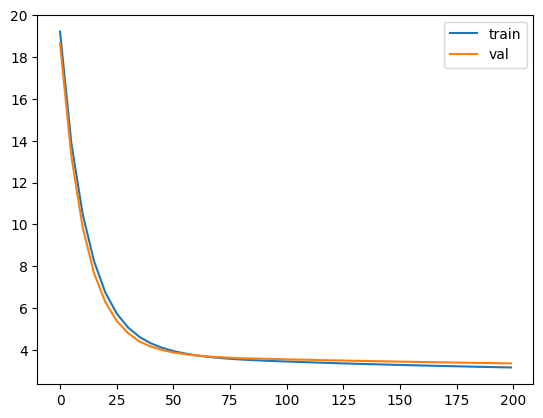

In [506]:

df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_score, label='train')
plt.plot(df_score.num_iter, df_score.val_score, label='val')
plt.legend()

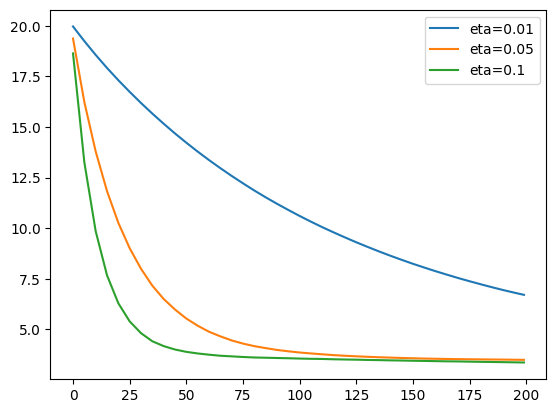

In [507]:
for eta, df_score in scores.items():
  plt.plot(df_score.num_iter, df_score.val_score, label=eta)

#plt.ylim(2, 5)
plt.legend()

In [316]:
scores={}

In [323]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [324]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

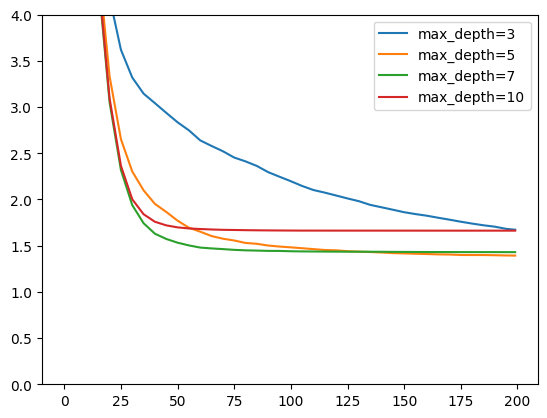

In [326]:
for max_depth, df_score in scores.items():
  plt.plot(df_score.num_iter, df_score.val_score, label=max_depth)

plt.ylim(0,4)
plt.legend()

In [327]:
scores={}

In [332]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 10,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [333]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

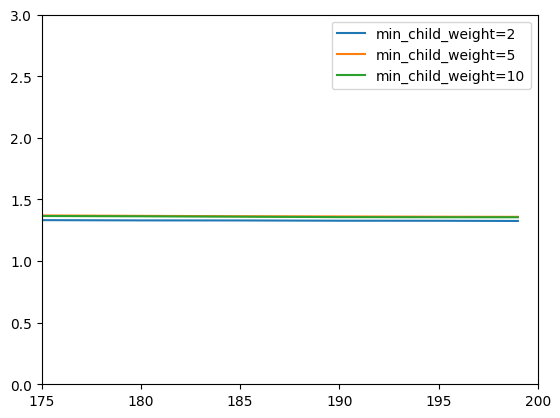

In [338]:
for min_child_weight, df_score in scores.items():
  plt.plot(df_score.num_iter, df_score.val_score, label=min_child_weight)

plt.ylim(0,3)
plt.xlim(175, 200)
plt.legend()

In [508]:
#%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 7,
    'min_child_weight': 10,
    'early_stopping_round':50,
    'gamma':0.1,
    'lambda':1,
    'alpha':0,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:18.70255	val-rmse:18.14974
[5]	train-rmse:11.33778	val-rmse:10.96071
[10]	train-rmse:6.97251	val-rmse:6.74801
[15]	train-rmse:4.38554	val-rmse:4.32932
[20]	train-rmse:2.84367	val-rmse:2.94720


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:59:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	train-rmse:1.93804	val-rmse:2.21219
[30]	train-rmse:1.40879	val-rmse:1.83049
[35]	train-rmse:1.10284	val-rmse:1.64840
[40]	train-rmse:0.89335	val-rmse:1.51307
[45]	train-rmse:0.75476	val-rmse:1.44815
[50]	train-rmse:0.65968	val-rmse:1.40264
[55]	train-rmse:0.58778	val-rmse:1.37153
[60]	train-rmse:0.52731	val-rmse:1.34503
[65]	train-rmse:0.48685	val-rmse:1.33261
[70]	train-rmse:0.44733	val-rmse:1.31926
[75]	train-rmse:0.41935	val-rmse:1.31456
[80]	train-rmse:0.38851	val-rmse:1.30619
[85]	train-rmse:0.36788	val-rmse:1.30234
[90]	train-rmse:0.35175	val-rmse:1.29900
[95]	train-rmse:0.33460	val-rmse:1.29441
[100]	train-rmse:0.31987	val-rmse:1.29293
[105]	train-rmse:0.30455	val-rmse:1.28753
[110]	train-rmse:0.28938	val-rmse:1.28721
[115]	train-rmse:0.27286	val-rmse:1.28439
[120]	train-rmse:0.26180	val-rmse:1.28176
[125]	train-rmse:0.24775	val-rmse:1.27992
[130]	train-rmse:0.23591	val-rmse:1.27787
[135]	train-rmse:0.22694	val-rmse:1.27751
[140]	train-rmse:0.22694	val-rmse:1.27751
[145]	t

In [509]:
y_pred = model.predict(dval)

rms = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 1.2775181750124234
Mean Absolute Error (MAE): 0.8112832196553548
Mean Squared Error (MSE): 1.6320526874870727
R-squared (R²): 0.995962381362915


Cross-validation

In [510]:
%%capture output

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['age_(years)']
    y_val = df_val['age_(years)']

    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')

    dv = DictVectorizer(sparse=True)

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    dtrain_fold = xgb.DMatrix(X_train, label=y_train)
    dval_fold = xgb.DMatrix(X_val, label=y_val)

    watchlist = [(dtrain_fold, 'train'), (dval_fold, 'val')]

    model_fold = xgb.train(xgb_params, dtrain_fold, num_boost_round=200,
                          verbose_eval=5, evals=watchlist)

    y_pred_fold = model_fold.predict(dval_fold)

    rms = root_mean_squared_error(y_val, y_pred_fold)
    mae = mean_absolute_error(y_val, y_pred_fold)
    mse = mean_squared_error(y_val, y_pred_fold)
    r2 = r2_score(y_val, y_pred_fold)

    print("Root Mean Squared Error (RMSE):", rms)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)
    scores.append(rms)

In [511]:
scores

[0.010858109923041639,
 0.012213537162272409,
 0.013107737374868202,
 0.012636523654578031,
 0.012237614546342805]

Chose model and proceed to full train

In [512]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['age_(years)']
del df_full_train['age_(years)']

In [513]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [514]:
d_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))

d_test = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [515]:
model = xgb.train(xgb_params, d_full_train, num_boost_round=200)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:00:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


In [516]:
y_pred = model.predict(d_test)

rms = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 1.2058419541983447
Mean Absolute Error (MAE): 0.788149897257487
Mean Squared Error (MSE): 1.454054818504883
R-squared (R²): 0.9965780377388


Export the model

In [517]:
output_file = f"model_xgb_eta={xgb_params['eta']}_score={rms.round(3)}.bin"

with open(output_file, "wb") as f_out:
    pickle.dump((dv, model), f_out)

print(f"the model is saved to {output_file}")

the model is saved to model_xgb_eta=0.1_score=1.206.bin


Final DataFrame

In [ ]:
df.iloc[0].to_dict()

{'gender': 'Male',
 'height_(cm)': 171.14835857585234,
 'weight_(kg)': 86.18519686940489,
 'blood_pressure_(s/d)': '151/109',
 'cholesterol_level_(mg/dl)': 259.46581350104714,
 'bmi': 29.423016908813725,
 'blood_glucose_level_(mg/dl)': 157.65284793866718,
 'bone_density_(g/cm²)': 0.1328682798964727,
 'vision_sharpness': 0.2,
 'hearing_ability_(db)': 58.78619834245858,
 'physical_activity_level': 'Moderate',
 'smoking_status': 'Former',
 'alcohol_consumption': 'Unknown',
 'diet': 'Low-carb',
 'chronic_diseases': 'Unknown',
 'medication_use': 'Unknown',
 'family_history': 'Unknown',
 'cognitive_function': 44.05917162252895,
 'mental_health_status': 'Good',
 'sleep_patterns': 'Insomnia',
 'stress_levels': 2.797064039425237,
 'pollution_exposure': 5.142344384136116,
 'sun_exposure': 7.108974826344509,
 'education_level': 'Unknown',
 'income_level': 'Medium',
 'age_(years)': 89,
 'systolic': 151,
 'diastolic': 109,
 'pulse_pressure': 42,
 'bone_density_category': 'Osteoporosis',
 'bone_dens

In [ ]:

df_unique_values_original = {
    'physical_activity_level': df.physical_activity_level.unique(),
    'smoking_status': df.smoking_status.unique(),
    'alcohol_consumption': df.alcohol_consumption.unique(),
    'diet': df.diet.unique(),
    'chronic_diseases': df.chronic_diseases.unique(),
    'medication_use': df.medication_use.unique(),
    'family_history': df.family_history.unique(),
    'mental_health_status': df.mental_health_status.unique(),
    'sleep_patterns': df.sleep_patterns.unique(),
    'education_level': df.education_level.unique(),
    'income_level': df.income_level.unique()
}

df_unique_values_original

{'physical_activity_level': array(['Moderate', 'Low', 'High'], dtype=object),
 'smoking_status': array(['Former', 'Current', 'Never'], dtype=object),
 'alcohol_consumption': array(['Unknown', 'Occasional', 'Frequent'], dtype=object),
 'diet': array(['Low-carb', 'Balanced', 'Vegetarian', 'High-fat'], dtype=object),
 'chronic_diseases': array(['Unknown', 'Hypertension', 'Diabetes', 'Heart Disease'],
       dtype=object),
 'medication_use': array(['Unknown', 'Regular', 'Occasional'], dtype=object),
 'family_history': array(['Unknown', 'Heart Disease', 'Hypertension', 'Diabetes'],
       dtype=object),
 'mental_health_status': array(['Good', 'Poor', 'Fair', 'Excellent'], dtype=object),
 'sleep_patterns': array(['Insomnia', 'Normal', 'Excessive'], dtype=object),
 'education_level': array(['Unknown', 'Undergraduate', 'High School', 'Postgraduate'],
       dtype=object),
 'income_level': array(['Medium', 'Low', 'High'], dtype=object)}

In [518]:
# save final DataFrame

df.to_csv('/datasets/modified_human_age_prediction.csv', index=False)

Test

In [401]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['age_(years)']
y_test = df_test['age_(years)']
del df_full_train['age_(years)']

dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

d_full_train = xgb.DMatrix(
    X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))

d_test = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

xgb_params = {
    'eta': 0.1,
    'max_depth': 7,
    'min_child_weight': 10,
    'early_stopping_round': 50,
    'gamma': 0.1,
    'lambda': 1,
    'alpha': 0,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_full_train, num_boost_round=200)

y_pred = model.predict(d_test)

rms = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rms)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:17:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 1.2058419541983447
Mean Absolute Error (MAE): 0.788149897257487
Mean Squared Error (MSE): 1.454054818504883
R-squared (R²): 0.9965780377388


In [238]:
dv.get_feature_names_out()

array(['age_group=Adults', 'age_group=Seniors', 'age_group=Youth', ...,
       'systolic', 'vision_sharpness', 'weight_(kg)'], dtype=object)

In [251]:
print('\n'.join(model.feature_names))

age_group=Adults
age_group=Seniors
age_group=Youth
alcohol_consumption=Frequent
alcohol_consumption=Occasional
alcohol_consumption=Unknown
blood_glucose_level_(mg/dl)
bmi
bone_cognitive_combined
bone_density_(g/cm²)
bone_density_category=Normal
bone_density_category=Osteopenia
bone_density_category=Osteoporosis
bone_density_decline_rate
bone_density_scaled
bone_vision_combined
cholesterol_level_(mg/dl)
chronic_diseases=Diabetes
chronic_diseases=Heart Disease
chronic_diseases=Hypertension
chronic_diseases=Unknown
cognitive_function
diastolic
diet=Balanced
diet=High-fat
diet=Low-carb
diet=Vegetarian
education_level=High School
education_level=Postgraduate
education_level=Undergraduate
education_level=Unknown
family_history=Diabetes
family_history=Heart Disease
family_history=Hypertension
family_history=Unknown
gender=Female
gender=Male
hearing_ability_(db)
hearing_age_interaction
hearing_category=Mild Loss
hearing_category=Moderate Loss
hearing_category=Normal
hearing_category=Profound L